<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Descente-de-Gradient-Stochastique" data-toc-modified-id="Descente-de-Gradient-Stochastique-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Descente de Gradient Stochastique</a></span></li><li><span><a href="#Mini-batch" data-toc-modified-id="Mini-batch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Mini-batch</a></span></li></ul></div>

Descente de Gradient Stochastique
===========================

La [Descente de Gradient Stochastique](http://en.wikipedia.org/wiki/Stochastic_gradient_descent) est une variante  [stochastique](http://en.wikipedia.org/wiki/Stochastic) de la descente de gradient, qui permet d'utiliser un algorithme efficace pour minimiser les fonctions de coût sous la forme d'une somme:

$$
  Q(\mathbf{w}) = \sum_{i=1}^{d} Q_i(\mathbf{w}) \; ,
$$

où $\mathbf{w}$ est un vecteur de paramètres (ou poids) à optimiser. La composante $Q_i$ est la contribution du $i$ème échantillon au coût total $Q$, qui est ce que l'on cherche précisémment à minimiser en utilisantun ensemble d'entraînement de $d$ échantillons.

En utilisant la descente de gradient standard, $Q$ peut être minimisée par l'itération suivante:

$\begin{eqnarray*}
  \mathbf{w}_{t+1} &=& \mathbf{w}_t - \eta \nabla Q \\
   &=& \mathbf{w}_t - \eta \sum_{i=1}^{d} \nabla Q_i(\mathbf{w}_t) \; ,\\
  \end{eqnarray*}$

où $\eta > 0$ est la taille du *pas*. Cette méthode d'itération par traitement de lots (*batch*) permet de calculer le coût total à chaque pas avec un temps de calcul qui est proportionnel à la taille $d$ de l'ensemble d'entraînement.

De manière similaire, dans la descente de gradient stochastique, $Q$ est minimisée en utilisant

$$
  \mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla Q_i (\mathbf{w}_t) \; ,
$$

en mettant à jour les poids $\mathbf{w}$ à chaque itération en utilisant juste un échantillon $i$ choisi aléatoirement de l'ensemble d'entraînement. Ceci est extrêmement efficace pour les grandes tailles d'échantillons, parce que cela permet d'obtenir un temps de calcul de chaque itération indépendant de $d$. Un autre avantage est que cela permet de traiter les échantillons à la volée, comme  une tâche d'[apprentissage en ligne](http://en.wikipedia.org/wiki/Online_machine_learning).

En pratique, au lieu d'un $\eta$ fixé, l'algorithme décroît la taille du pas  $\eta_t$ pour améliorer la convergence.

On va implémenter une version avec pas constant.

In [1]:
import torch
import torch.utils.data
import numpy as np

Dans cette implémentation $Q_i$ a la forme



$$Q_i(\mathbf{w}) = \left\Vert \mathbf{y}_i - f_{\mathbf{w}} (\mathbf{x}_i) \right\Vert \; ,$$


où $f_{\mathbf{w}} : \mathbb{R}^n \to \mathbb{R}^m$  est une fonction *modèle* pour notre jeu de données, paramétrisée par $\mathbf{w}$; $\mathbf{x}_i \in \mathbb{R}^n$ et $\mathbf{y}_i \in \mathbb{R}^m$ sont la paire d'entrées/sorties pour l'$i$ème échantillon de l'ensemble d'apprentissage. Trouver les paramètres $\mathbf{w}$ qui minimisent $Q(\mathbf{w}) = \sum_{i=1}^{d} Q_i (\mathbf{w})$ et qui ajuste la fonction modèle $f_{\mathbf{w}}$ à nos données.



On va le tester grâce à l'[ajustement de courbe](http://en.wikipedia.org/wiki/Curve_fitting)(*curve fitting*) suivante :



$$f_{\mathbf{w}} (x) = w_1 x^2 + w_2 x + w_3$$

In [2]:
def f(w,x):
    return w[0] * x * x + w[1] * x + w[2]

Commençons par définir notre jeu de données

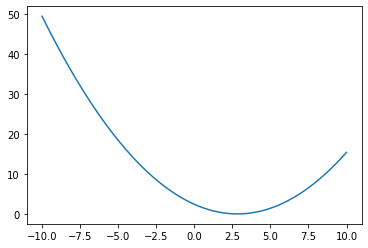

In [6]:
wt = [0.3,-1.7,2.5] # Ce sont les paramètres que l'on va essayer de retrouver
xtrain = np.arange(-10,10,0.01,dtype='f')
ytrain = (lambda x : f(wt,x))(xtrain)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(xtrain,ytrain);

Pour traiter notre ensemble d'entraînement il faut mettre ensemble entrées(*input*) et sorties(*target*), via la fonction `concatenate`.

In [7]:
xtrainnp = np.array([xtrain])
ytrainnp = np.array([ytrain])
dataTconcat = np.concatenate((xtrainnp,ytrainnp))
points = np.transpose(dataTconcat)
points

array([[-10.      ,  49.5     ],
       [ -9.99    ,  49.423027],
       [ -9.98    ,  49.346115],
       ...,
       [  9.970457,  15.373228],
       [  9.980457,  15.416082],
       [  9.990458,  15.458996]], dtype=float32)

On initialise les paramètres $w$

In [4]:
w0 = torch.zeros(3,requires_grad=True)

Dans une première version de la *SGD* naïve, on va itérer sur tous les échantillons et incrémenter notre vecteur de poids sur chacun d'eux.

On aura une fonction :
```python
def sgd(f,w,t,eta=0.00001, epsilon=0.001,nepoch=100):
```
où `eta` est la taille du pas, `epsilon` la limite de convergence du coût, et `nepoch` le nombre maximum de fois où l'on aura parcouru tous les échantillons.

### Exercice 1

Compléter le code ci-dessous pour faire une descente de gradient

In [8]:
# Installer tqdm et éventuellement ipywidgets
# from tqdm import tqdm # Si pas ipywidgets
from tqdm.notebook import tqdm 

def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=20):
    bar = tqdm(total=nepoch) # 
    epoch = 0
    x = t[:,0]
    y = t[:,1]
    while(epoch < nepoch):
        loss = torch.mean(torch.pow(y-f(w,x),2))
        loss.backward()
        w.data.sub_(eta * w.grad)
        w.grad.data.zero_()
        bar.update() # Affichage
        bar.set_description("loss %f" % loss.item())
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [9]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=0.0002,epsilon=0.1,nepoch=10000)

convergence au bout de 9340 epochs.


On vérifie que l'on s'est rapproché des paramètres du modèle.

In [10]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3079, -1.7000,  2.0258], requires_grad=True)


tensor(0.4743, grad_fn=<NormBackward0>)

### Exercice 2

Légère simplification, utiliser la fonction de coût toute faite `torch.nn.MSELoss()`
```python
criterion = torch.nn.MSELoss()
```

Ecrire la version du sgd avec cette fonction de coût "prête à l'emploi"

In [ ]:
def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=20):
    bar = tqdm(total=nepoch) # 
    epoch = 0
    criterion = torch.nn.MSELoss()
    x = t[:,0]
    y = t[:,1]
    while(epoch < nepoch):
        loss = criterion(f(w,x),y)
        loss.backward()
        w.data.sub_(eta * w.grad)
        w.grad.data.zero_()
        bar.update() # Affichage
        bar.set_description("loss %f" % loss.item())
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [ ]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=0.0002,epsilon=0.1,nepoch=10000)

# Mini-batch

On va maintenant mettre en placer la vraie version *minibatch* du SGD.
Pour ce faire, on utilise directement les facilités du [`DataLoader`](https://pytorch.org/docs/stable/data.html)  de `pytorch`, qui combine un jeu de données et un échantilloneur.

In [11]:
trainloader = torch.utils.data.DataLoader(points,batch_size=10,shuffle=True)

### Exercice 3

énumérer tous les éléments de chaque batch avec le print suivant

In [ ]:
# print("batch %i, échantillon %i : x = %f, y = %f" % (i,j,x.item(),y.item()))

### Exercice 4

Réécrire la descente de gradient version mini-batch en utilisant le `trainloader`.
Attention pour le calcul du coût il faut maintenant cumuler sur tous les batch à chaque époque. Bien réfléchir à la bonne stratégie.

In [12]:
def sgd(f,w,t,eta=0.0001, epsilon=0.01,nepoch=200,minibatch=10):
    epoch = 0    
    bar = tqdm(total=nepoch)
    criterion = torch.nn.MSELoss()
    trainloader = torch.utils.data.DataLoader(t,batch_size=minibatch,shuffle=True)
    while(epoch < nepoch):
        running_loss = 0.
        for data in trainloader:
            x , y = data[:,0],data[:,1]
            loss = criterion(f(w,x),y)
            loss.backward()
            w.data.sub_(eta * w.grad)
            w.grad.data.zero_()
            running_loss = running_loss + loss.item() * len(data)
        running_loss = running_loss / len(t)
        bar.update()
        bar.set_description("loss %f" % running_loss)
        epoch += 1
        if (running_loss < epsilon):
            print("convergence au bout de %i epochs." % epoch)
            break

In [14]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),eta=02,epsilon=0.1,nepoch=50)

convergence au bout de 48 epochs.


In [15]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3072, -1.7006,  2.0476], requires_grad=True)


tensor(0.4525, grad_fn=<NormBackward0>)

Maintenant il nous reste plus qu'à utiliser les optimiseurs de [`torch.optim`](https://pytorch.org/docs/stable/optim.html) comme `Adam`, `RMSProp` etc.

il faut charger l'optimiseur avec les paramètres $w$
```python
optimizer = torch.optim.Adam([w], lr=lr)
```

Après chaque rétropropagation, on peut appeler `optimizer.step()`: cela mettra effecturea directement le "pas" de descente et remet à zéro les gradients, on n'a plus besoin de le faire.

### Exercice 5

Version du sgd avec l'optimiseur RMSprop.

In [16]:
def sgd(f,w,t,lr=0.01, epsilon=0.01,nepoch=200,minibatch=10):
    epoch = 0
    bar = tqdm(total=nepoch)
    optimizer = torch.optim.RMSprop([w], lr=lr)
    trainloader = torch.utils.data.DataLoader(t,batch_size=minibatch,shuffle=True)
    criterion = torch.nn.MSELoss()
    while (epoch < nepoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            optimizer.zero_grad()
            x, y = data[:,0],data[:,1]
            loss = criterion(f(w,x),y)
            running_loss = running_loss + loss.item() * len(data)
            loss.backward()
            optimizer.step()
        running_loss = running_loss / len(t)
        bar.update()
        bar.set_description("loss %f" % running_loss)
        epoch += 1
        if (loss.item() < epsilon):
            print("convergence au bout de %i itérations." % epoch)
            break

In [19]:
w0 = torch.zeros(3,requires_grad=True)
sgd(f,w0,torch.tensor(points),epsilon=1e-7,nepoch=50)

convergence au bout de 23 itérations.


In [20]:
print(wt)
print(w0)
torch.norm(torch.tensor(wt)-w0)

[0.3, -1.7, 2.5]
tensor([ 0.3000, -1.7000,  2.4999], requires_grad=True)


tensor(0.0001, grad_fn=<NormBackward0>)

### Exercice 6

Réessayer les sgd avec l'option shuffle=False dans le trainloader. Que constatez-vous ? Quelle explication ?

### Exercice 7

- Comparer dans la sgd la fonction de coût $L(X,Y)$ sur l'ensemble des points avec la somme des fonctions de coûts des batchs $\sum{L(X_i,Y_i)}$ déj). Comment expliquer la différence ? Est-ce grave docteur ? (indice, penser à l'inégalité triangulaire)
- Même question mais pour la norme du gradient.